# Team 1

# IoT Project : Gas sensors for home activity monitoring Data Set

This notebook holds the code for our project. It includes 2 raw files (HT_Sensor_dataset.dat, HT_Sensor_metadata.dat) which is preprocessed and fed to two models one being **LSTM** and other being **CNN**. Both of them try to predict 3 stimuli classes **Background, Banana and Wine** from time, temperature and humidity. There are graphs which show relation beetween attributes, accuracies and loses of the models.

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Adding  Supporting Libraries

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import keras

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.layers.core import Activation
from keras.utils import pad_sequences
from keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Flatten
from sklearn.linear_model import LinearRegression

2023-05-08 18:20:20.867611: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#importing additional libraries or define helper functions
x_columns = ['id','time','R1','R2','R3','R4','R5','R6','R7','R8','Temp','Humidity']

## Loading First file (HT_Sensor_dataset.dat)

In [4]:
#Reading HT_Sensor_dataset.dat file using pandas
dataset = pd.read_table("HT_Sensor_dataset.dat")

In [5]:
#Splitting the id time column and storing it into a list
dataset_split = []
for i in dataset['id time']:
    dataset_split.append(i.split())

In [6]:
#Converting the list into DataFrame with HT_Sensor_dataset column names
dataset = pd.DataFrame(dataset_split ,columns = x_columns)

In [7]:
#Printing dataset information
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 928991 entries, 0 to 928990
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        928991 non-null  object
 1   time      928991 non-null  object
 2   R1        928991 non-null  object
 3   R2        928991 non-null  object
 4   R3        928991 non-null  object
 5   R4        928991 non-null  object
 6   R5        928991 non-null  object
 7   R6        928991 non-null  object
 8   R7        928991 non-null  object
 9   R8        928991 non-null  object
 10  Temp      928991 non-null  object
 11  Humidity  928991 non-null  object
dtypes: object(12)
memory usage: 85.1+ MB


In [8]:
#convert all data columns to float types
dataset['id'] = dataset['id'].astype(int)
dataset[['time','R1','R2','R3','R4','R5','R6','R7','R8','Temp','Humidity']] = dataset[['time','R1','R2','R3','R4','R5','R6','R7','R8','Temp','Humidity']].astype(float)

#Printing dataset information after changing datatype
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 928991 entries, 0 to 928990
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        928991 non-null  int64  
 1   time      928991 non-null  float64
 2   R1        928991 non-null  float64
 3   R2        928991 non-null  float64
 4   R3        928991 non-null  float64
 5   R4        928991 non-null  float64
 6   R5        928991 non-null  float64
 7   R6        928991 non-null  float64
 8   R7        928991 non-null  float64
 9   R8        928991 non-null  float64
 10  Temp      928991 non-null  float64
 11  Humidity  928991 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 85.1 MB


In [9]:
dataset.head()

,id,time,R1,R2,R3,R4,R5,R6,R7,R8,Temp,Humidity
0,0,-0.999750,12.8621,10.3683,10.4383,11.6699,13.4931,13.3423,8.04169,8.73901,26.2257,59.0528
1,0,-0.999472,12.8617,10.3682,10.4375,11.6697,13.4927,13.3412,8.04133,8.73908,26.2308,59.0299
2,0,-0.999194,12.8607,10.3686,10.4370,11.6696,13.4924,13.3405,8.04101,8.73915,26.2365,59.0093
3,0,-0.998916,12.8602,10.3686,10.4370,11.6697,13.4921,13.3398,8.04086,8.73936,26.2416,58.9905
4,0,-0.998627,12.8595,10.3688,10.4374,11.6699,13.4919,13.3390,8.04087,8.73986,26.2462,58.9736


## Loading Second file (HT_Sensor_metadata.dat)

In [10]:
#Reading HT_Sensor_metadata.dat file using pandas
metadata = pd.read_table("HT_Sensor_metadata.dat")

In [11]:
#Renaming some columns and dropping one extra column 
metadata.rename(columns = {'dt':'dt1','t0':'dt','class':'t0','Unnamed: 2':'class'}, inplace = True)
metadata = metadata.drop('dt1',axis=1)

In [12]:
#Converting categories to numerical class values in a list
categories = []
for filename in metadata["class"]:
    if filename == 'banana':
        categories.append(1)
    elif filename == 'wine':
         categories.append(2)  
    else:
        categories.append(0)

In [13]:
#Adding a new column categories into metadata with column name as Target
categories = pd.DataFrame(categories)
categories.columns = ["Target"]
metadata["Target"] = categories

In [14]:
#Merging both Dataframes into one based on the default id column.
data = pd.merge(dataset, metadata)

#Adding both time and t0 column to make 12 hours time column and dropping t0 column
data['time']  += data['t0']
data.drop(['t0'],axis = 1,inplace=True)

## Converting Time and Date column to Adjust Unix Format

In [15]:
#Converting time into hh:mm:ss format 
time = []
for i in data['time']:
    hours = i
    seconds = int(hours * 3600)
    hhmmss = str(datetime.timedelta(seconds=seconds))
    time.append(hhmmss)

#convert datetime to epoch/unix time
data['time1'] = time
data['date'] = pd.to_datetime(data['date'].astype(str), infer_datetime_format=True).dt.strftime('%d-%m-%y')
data['Datetime'] = pd.to_datetime(data['date'].astype(str) + ' ' + data['time1'].astype(str))
data['Datetime'] = pd.to_datetime(data['Datetime'])
data['unix'] = pd.to_datetime(data['Datetime']).map(pd.Timestamp.timestamp).astype(int)
data['Target'] = data['Target'].astype(int)
data.head()

,id,time,R1,R2,R3,R4,R5,R6,R7,R8,Temp,Humidity,date,class,dt,Target,time1,Datetime,unix
0,0,12.490250,12.8621,10.3683,10.4383,11.6699,13.4931,13.3423,8.04169,8.73901,26.2257,59.0528,04-07-15,banana,1.64,1,12:29:24,2015-04-07 12:29:24,1428409764
1,0,12.490528,12.8617,10.3682,10.4375,11.6697,13.4927,13.3412,8.04133,8.73908,26.2308,59.0299,04-07-15,banana,1.64,1,12:29:25,2015-04-07 12:29:25,1428409765
2,0,12.490806,12.8607,10.3686,10.4370,11.6696,13.4924,13.3405,8.04101,8.73915,26.2365,59.0093,04-07-15,banana,1.64,1,12:29:26,2015-04-07 12:29:26,1428409766
3,0,12.491084,12.8602,10.3686,10.4370,11.6697,13.4921,13.3398,8.04086,8.73936,26.2416,58.9905,04-07-15,banana,1.64,1,12:29:27,2015-04-07 12:29:27,1428409767
4,0,12.491373,12.8595,10.3688,10.4374,11.6699,13.4919,13.3390,8.04087,8.73986,26.2462,58.9736,04-07-15,banana,1.64,1,12:29:28,2015-04-07 12:29:28,1428409768


## Temprature & Humidity Reading

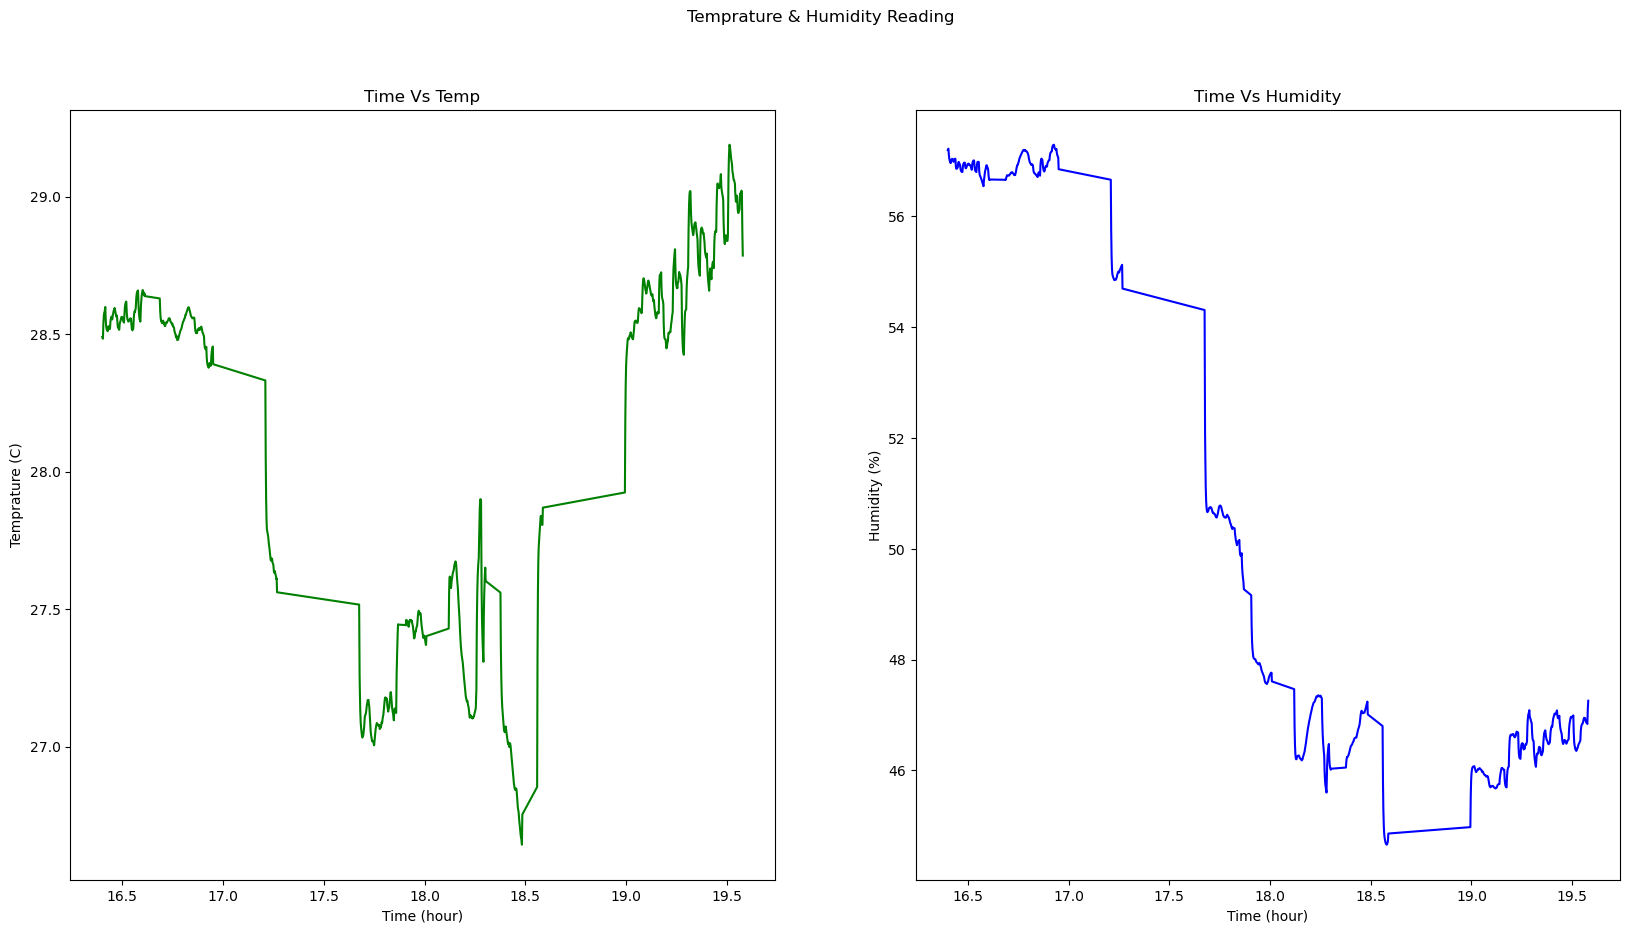

In [251]:
figure, ax = plt.subplots(nrows=1, ncols=2)
figure.set_figheight(10)
figure.set_figwidth(20)

ax[0].plot(data.time[data.id == 20],data['Temp'][data.id == 20],c = 'green')
ax[0].set_title('Time Vs Temp')
ax[0].set_xlabel('Time (hour)')
ax[0].set_ylabel('Temprature (C)')
ax[1].plot(data.time[data.id == 20],data.Humidity[data.id == 20],c = 'blue')
ax[1].set_title('Time Vs Humidity')
ax[1].set_xlabel('Time (hour)')
ax[1].set_ylabel('Humidity (%)')
plt.suptitle('Temprature & Humidity Reading')
plt.savefig("Temprature & Humidity Reading.png", dpi=500)

<AxesSubplot:>

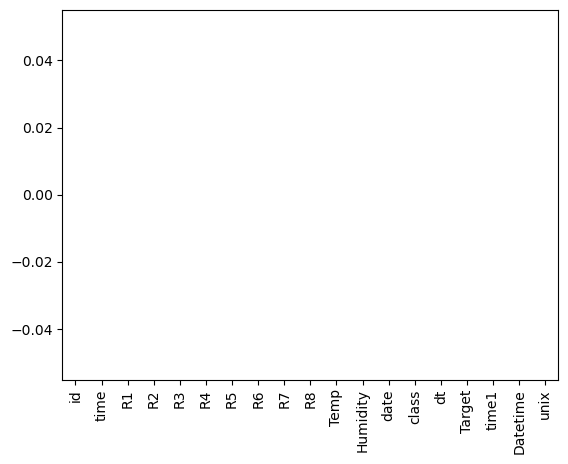

In [17]:
#checking the plot once to visualize missing data after clean up
data.isna().sum().plot.bar()

## Splitting Huge Dataset into Smaller chunk

In [18]:
#create your training and validation sets here
#assign size for data subset
subset_size = int(len(data) * 0.01)

#take random data subset
df_subset = data.sample(n=subset_size, random_state=32)

#split data subset 80/20 for train/validation
train_df, val_df = train_test_split(df_subset, train_size=0.8, random_state=32)

In [19]:
#reset the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

# Linear Regression for Temperature, Humidity and Sensor 1

In [20]:
ts = pd.DataFrame(data.unix)
ys = pd.DataFrame(data[['Temp','Humidity','R1']].rolling(30).mean())
ys = ys[29:]

ph = 1 #1 minutes
ph_index = round(ph / 60) #ph/data resolution
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5001

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)
hp_pred = np.zeros(n_s-1)
rp_pred = np.zeros(n_s-1)

In [21]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)

    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)

    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_
    
    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0] + ph
    yp = m_tmp[0]*tp + q_tmp[0]
    hp = m_tmp[1]*tp + q_tmp[1]
    rp = m_tmp[2]*tp + q_tmp[2]

    tp_pred[i-2] = tp
    yp_pred[i-2] = yp
    hp_pred[i-2] = hp
    rp_pred[i-2] = rp

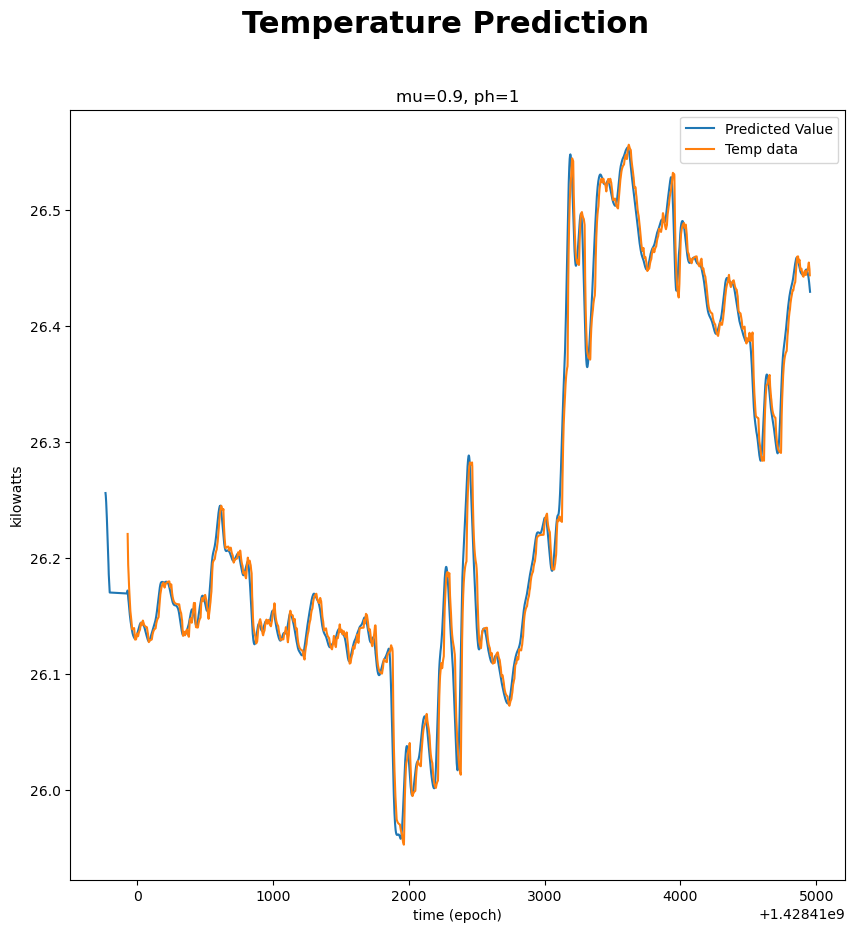

In [22]:
#Plot data points/predictions for Temperature
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Temperature Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu=%g, ph=%g' %(mu, ph))
ax.plot(tp_pred[:], yp_pred[:], label='Predicted Value')
ax.plot(data['unix'].iloc[29:5000], data['Temp'].iloc[29:5000], label='Temp data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

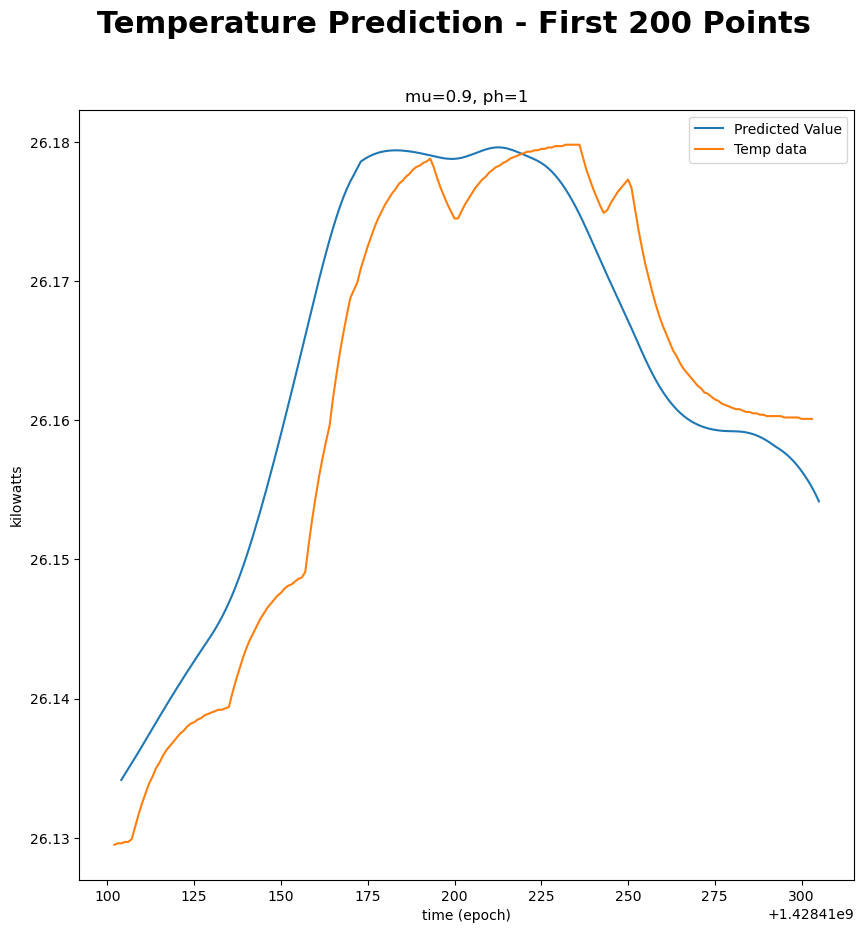

In [252]:
#Plot first second 200 data points/predictions for Temperature
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Temperature Prediction - First 200 Points', fontsize=22, fontweight='bold')
ax.set_title('mu=%g, ph=%g' %(mu, ph))
ax.plot(tp_pred[200:400], yp_pred[200:400], label='Predicted Value')
ax.plot(data['unix'].iloc[200:400], data['Temp'].iloc[200:400], label='Temp data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

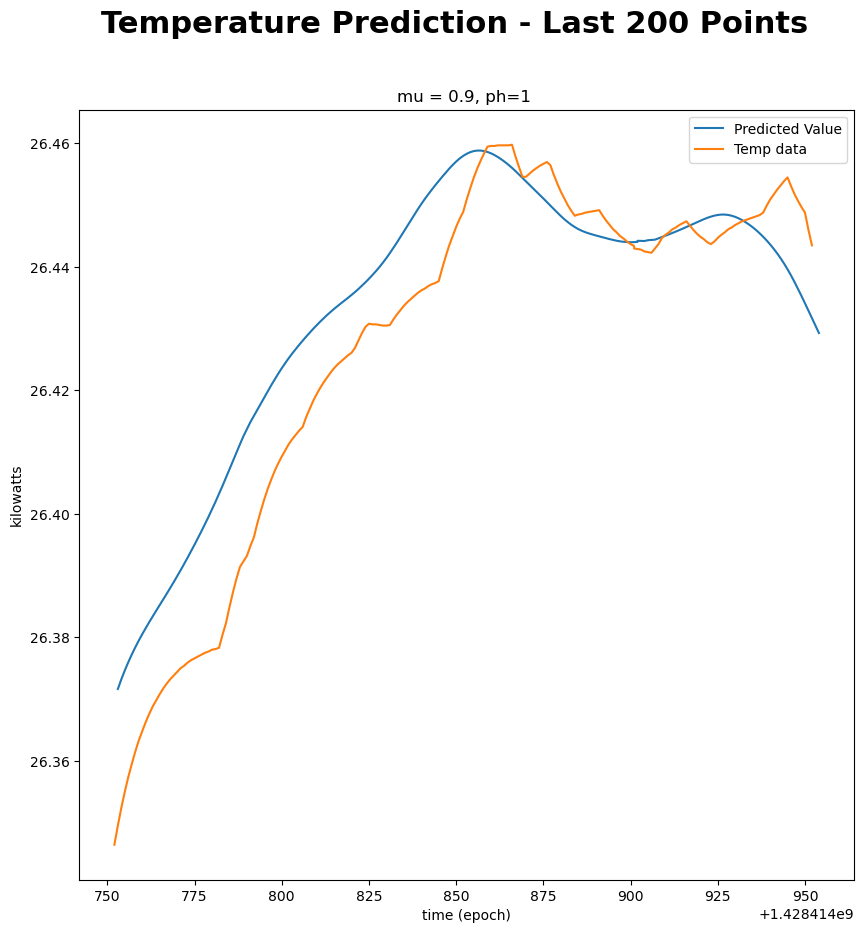

In [24]:
#Plot last 200 data points/predictions for a Temperature
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Temperature Prediction - Last 200 Points', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(data['unix'].iloc[n_s-200:5000], data['Temp'].iloc[n_s-200:5000], label='Temp data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

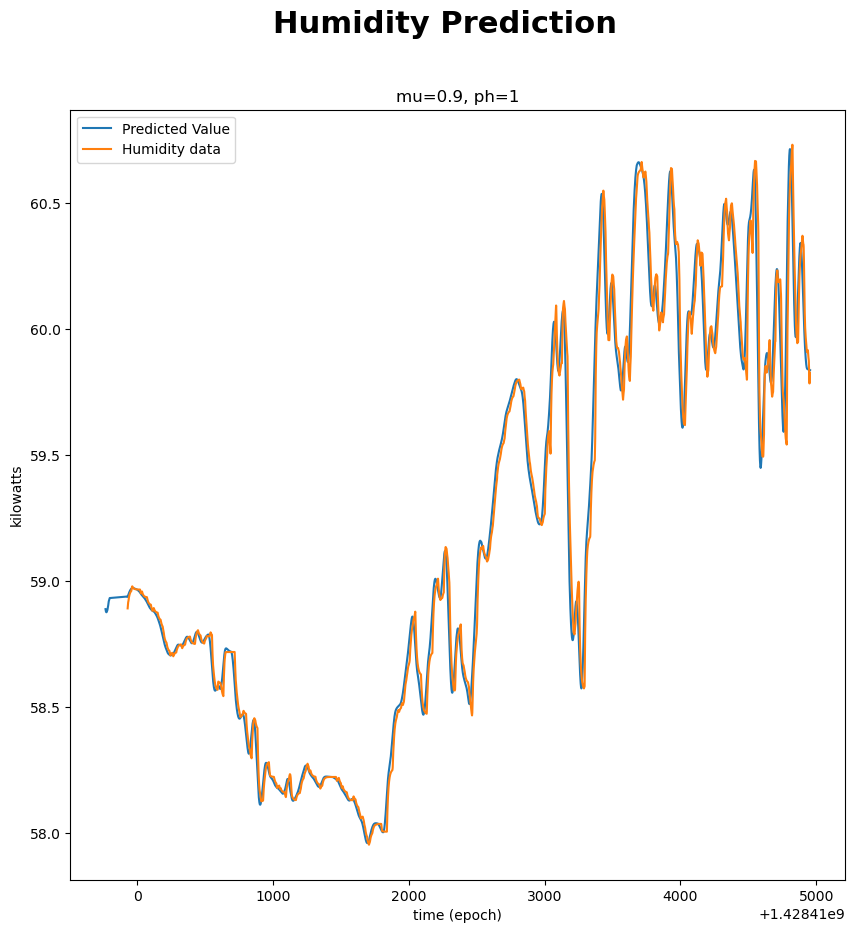

In [25]:
#Plot data points/predictions for Humidity
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Humidity Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu=%g, ph=%g' %(mu, ph))
ax.plot(tp_pred[0:], hp_pred[0:], label='Predicted Value')
ax.plot(data['unix'].iloc[29:5000], data['Humidity'].iloc[29:5000], label='Humidity data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

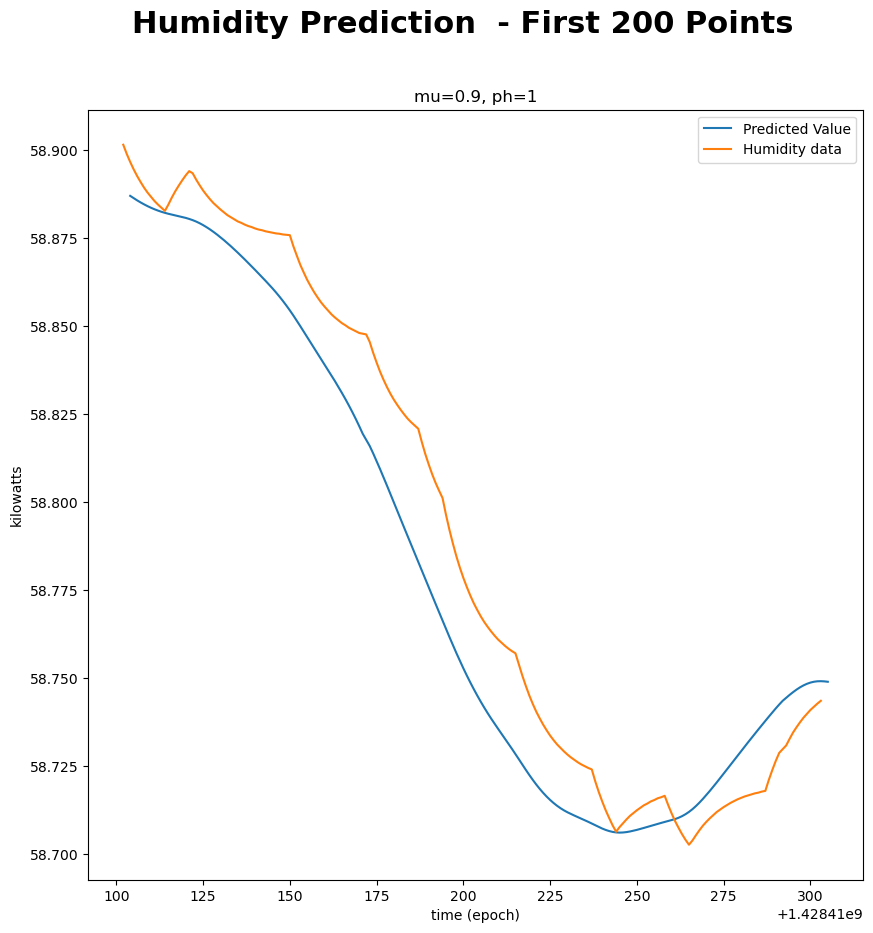

In [258]:
#Plot first second 200 data points/predictions for Humidity
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Humidity Prediction  - First 200 Points', fontsize=22, fontweight='bold')
ax.set_title('mu=%g, ph=%g' %(mu, ph))
ax.plot(tp_pred[200:400], hp_pred[200:400], label='Predicted Value')
ax.plot(data['unix'].iloc[200:400], data['Humidity'].iloc[200:400], label='Humidity data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

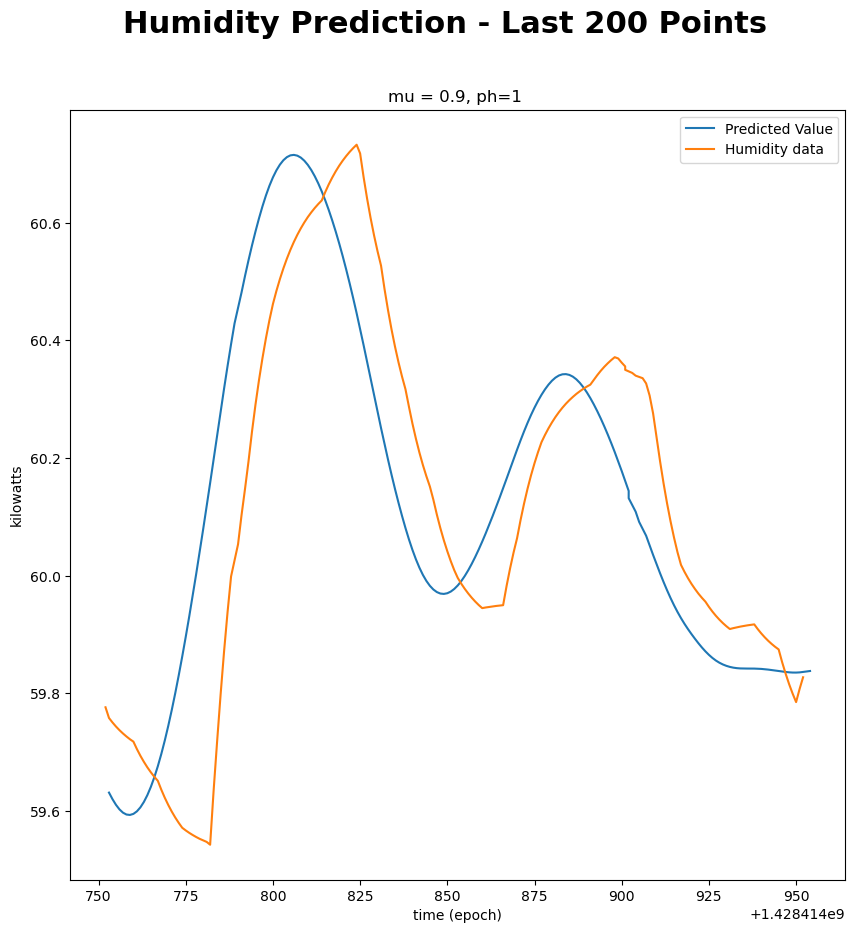

In [27]:
#Plot last 200 data points/predictions for a Humidity
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Humidity Prediction - Last 200 Points', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], hp_pred[-200:], label='Predicted Value')
ax.plot(data['unix'].iloc[n_s-200:5000], data['Humidity'].iloc[n_s-200:5000], label='Humidity data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

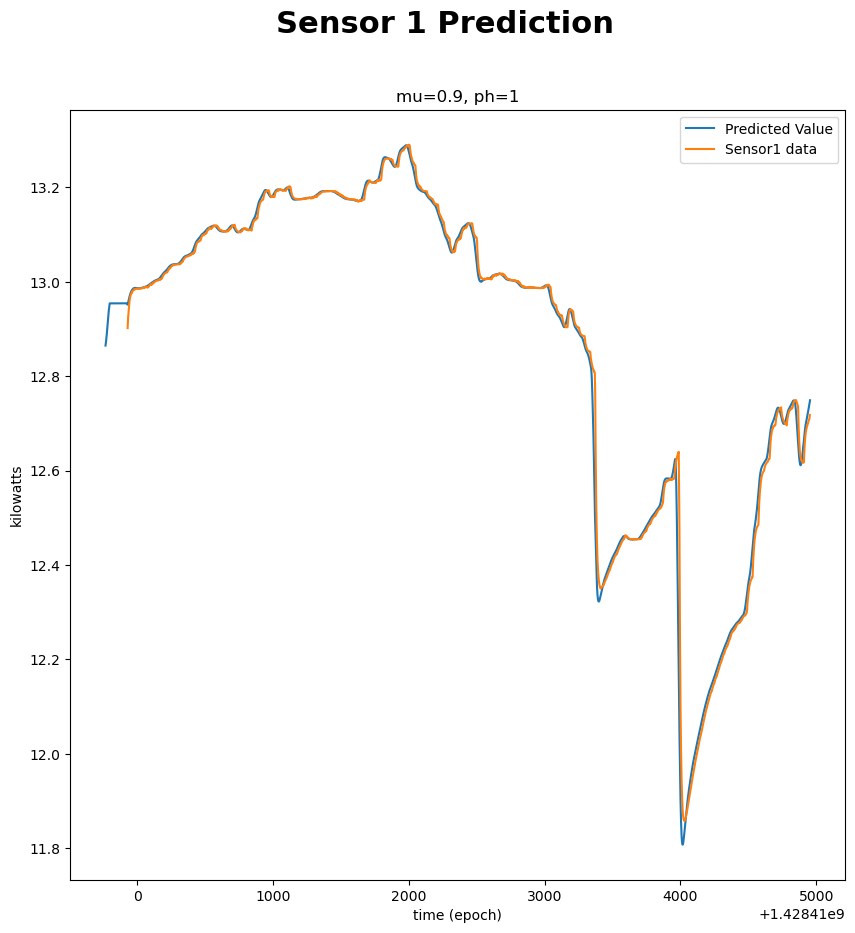

In [254]:
#Plot data points/predictions for Sensor1
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Sensor 1 Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu=%g, ph=%g' %(mu, ph))
ax.plot(tp_pred[0:], rp_pred[0:], label='Predicted Value')
ax.plot(data['unix'].iloc[29:5000], data['R1'].iloc[29:5000], label='Sensor1 data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

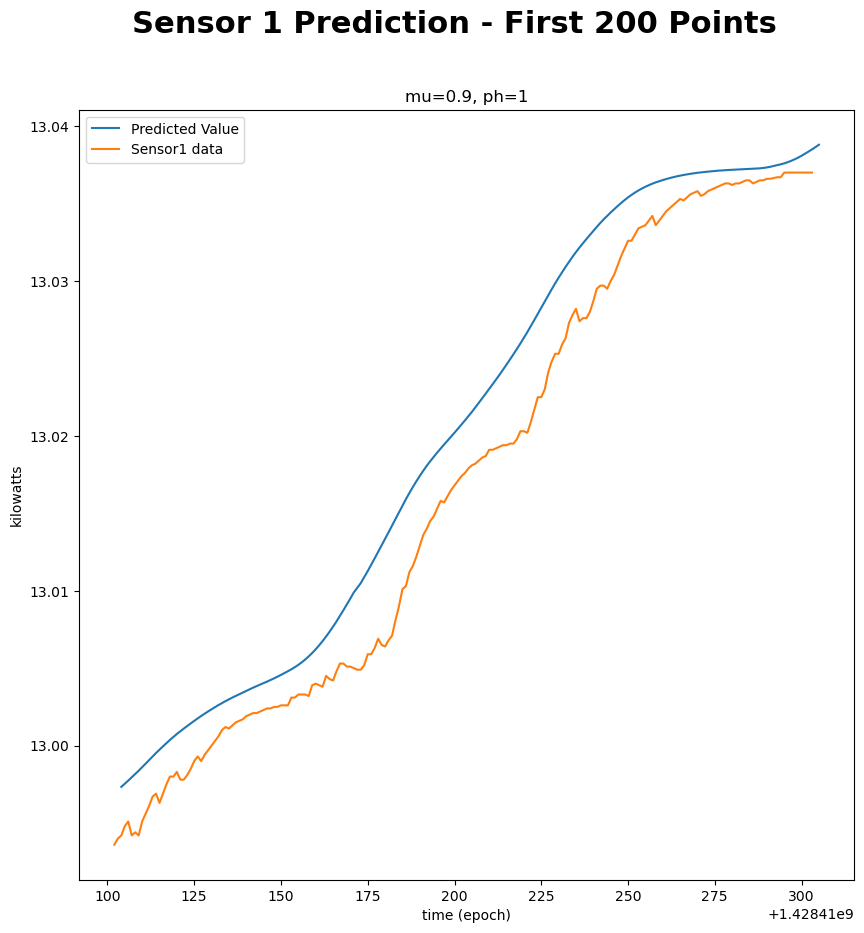

In [255]:
#Plot first second 200 data points/predictions for Sensor1
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Sensor 1 Prediction - First 200 Points', fontsize=22, fontweight='bold')
ax.set_title('mu=%g, ph=%g' %(mu, ph))
ax.plot(tp_pred[200:400], rp_pred[200:400], label='Predicted Value')
ax.plot(data['unix'].iloc[200:400], data['R1'].iloc[200:400], label='Sensor1 data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

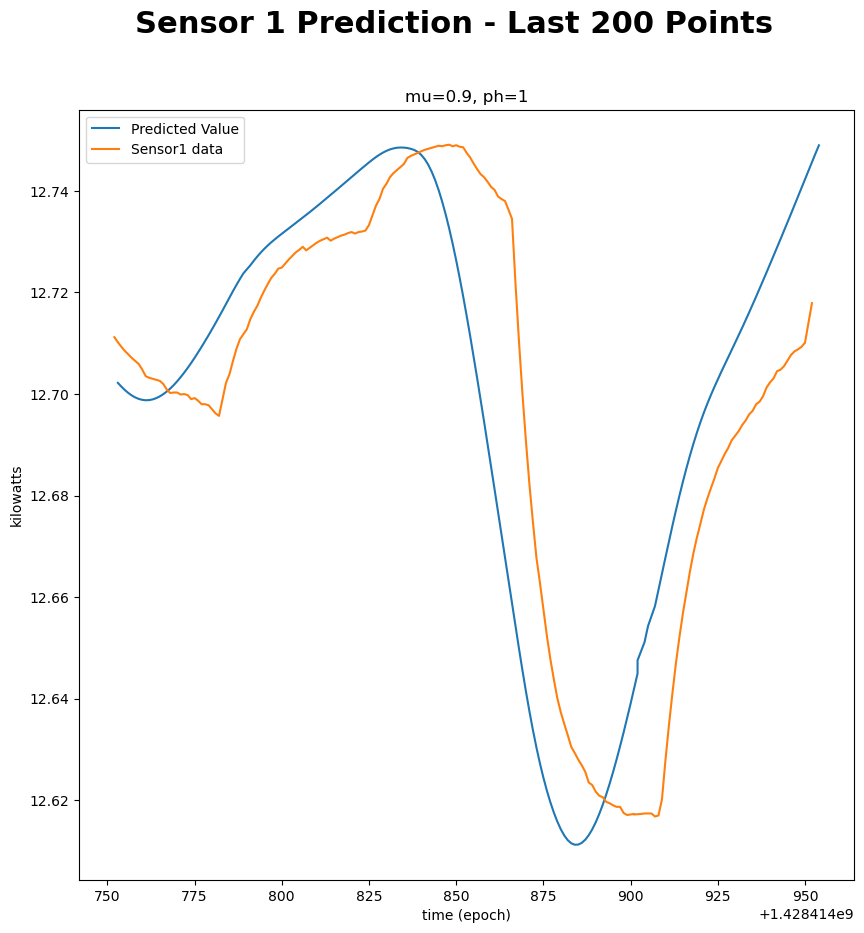

In [257]:
#Plot last 200 data points/predictions for a Sensor1
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Sensor 1 Prediction - Last 200 Points', fontsize=22, fontweight='bold')
ax.set_title('mu=%g, ph=%g' %(mu, ph))
ax.plot(tp_pred[-200:], rp_pred[-200:], label='Predicted Value')
ax.plot(data['unix'].iloc[n_s-200:5000], data['R1'].iloc[n_s-200:5000], label='Sensor1 data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

In [31]:
#Saving the Predicted data into a DataFrame
data_file = data[:5000]
data_file['Temp_Pred'] = yp_pred
data_file['Humidity_Pred'] = hp_pred
data_file['R1_Pred'] = rp_pred

In [32]:
#Saving the DataFrame into a CSV file
data_file.to_csv("household_power_thr.csv")

# LSTM

## Model Training

In [70]:
seq_arrays = []
seq_labs = []

In [71]:
# we'll start out with a 30 minute input sequence and a 1 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 18
num_classes = 3
sequence_cols = ['time','Temp','Humidity']

#create list of sequence length Target readings
for idx in train_df['id'].unique():
    id_df = train_df[train_df.id == idx]
    num_rows = len(id_df)
    for start in range(0,num_rows-seq_length):
        seq_arrays.append(id_df[sequence_cols].iloc[start:start+seq_length].to_numpy())
        seq_labs.append(id_df['Target'].iloc[start:start+seq_length].to_numpy()[-1])

#convert to numpy arrays and floats to appease keras/tensorflow     
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)

#convert to numpy arrays and floats to appease keras/tensorflow with eye to convert into classes array
seq_labs = np.array(np.eye(num_classes)[seq_labs], dtype = object).astype(np.float32)

In [72]:
# define path to save model
model_path = 'classification_model.h5'

# The first layer is an Conv1D layer with 48 units followed by another Conv1D layer with 64 units and 128 units. 
# BatchNormalization is also applied after each Conv1D layer.
# This is followed by a 100 unit LSTM layer.
# Final layer is a Dense output layer with 3 unit and softmax activation since this is a classification problem.
# build the network
nb_features = seq_arrays.shape[2]
nb_out = seq_labs.shape[1]

model = Sequential()
model.add(Conv1D(48,input_shape=(seq_length, nb_features),kernel_size=2, padding="causal",activation="relu"))
model.add(BatchNormalization())
model.add(Conv1D(64,kernel_size=2,padding="causal",activation="relu",dilation_rate=2))
model.add(BatchNormalization())
model.add(Conv1D(128,kernel_size=2,padding="causal",activation="relu",dilation_rate=4))
model.add(BatchNormalization())

# add first LSTM layer
model.add(LSTM(100))
model.add(Dense(units=nb_out, activation='softmax'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) #define parameters

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 18, 48)            336       
                                                                 
 batch_normalization_9 (Batc  (None, 18, 48)           192       
 hNormalization)                                                 
                                                                 
 conv1d_10 (Conv1D)          (None, 18, 64)            6208      
                                                                 
 batch_normalization_10 (Bat  (None, 18, 64)           256       
 chNormalization)                                                
                                                                 
 conv1d_11 (Conv1D)          (None, 18, 128)           16512     
                                                                 
 batch_normalization_11 (Bat  (None, 18, 128)         

In [83]:
# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=200, validation_split=0.02, verbose=2,
              callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                           keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

# list all data in history
print(history.history.keys())

Epoch 1/100
28/28 - 2s - loss: 0.0280 - accuracy: 0.9906 - val_loss: 5.8702 - val_accuracy: 0.4513 - 2s/epoch - 68ms/step
Epoch 2/100
28/28 - 2s - loss: 0.0338 - accuracy: 0.9874 - val_loss: 2.2150 - val_accuracy: 0.5575 - 2s/epoch - 65ms/step
Epoch 3/100
28/28 - 2s - loss: 0.0339 - accuracy: 0.9883 - val_loss: 3.5534 - val_accuracy: 0.5398 - 2s/epoch - 62ms/step
Epoch 4/100
28/28 - 2s - loss: 0.0360 - accuracy: 0.9888 - val_loss: 1.9082 - val_accuracy: 0.5487 - 2s/epoch - 65ms/step
Epoch 5/100
28/28 - 2s - loss: 0.0294 - accuracy: 0.9919 - val_loss: 8.0091 - val_accuracy: 0.0354 - 2s/epoch - 61ms/step
Epoch 6/100
28/28 - 2s - loss: 0.0181 - accuracy: 0.9940 - val_loss: 5.5281 - val_accuracy: 0.4248 - 2s/epoch - 62ms/step
Epoch 7/100
28/28 - 2s - loss: 0.0395 - accuracy: 0.9886 - val_loss: 7.5154 - val_accuracy: 0.4336 - 2s/epoch - 61ms/step
Epoch 8/100
28/28 - 2s - loss: 0.0232 - accuracy: 0.9924 - val_loss: 1.1708 - val_accuracy: 0.8407 - 2s/epoch - 69ms/step
Epoch 9/100
28/28 - 2s -

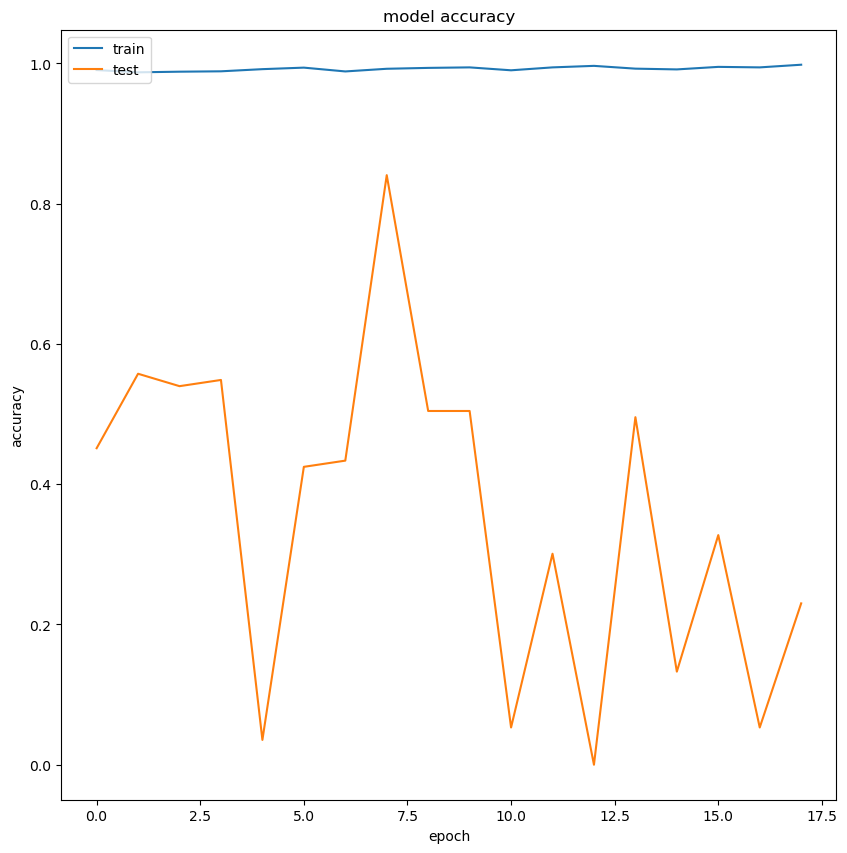

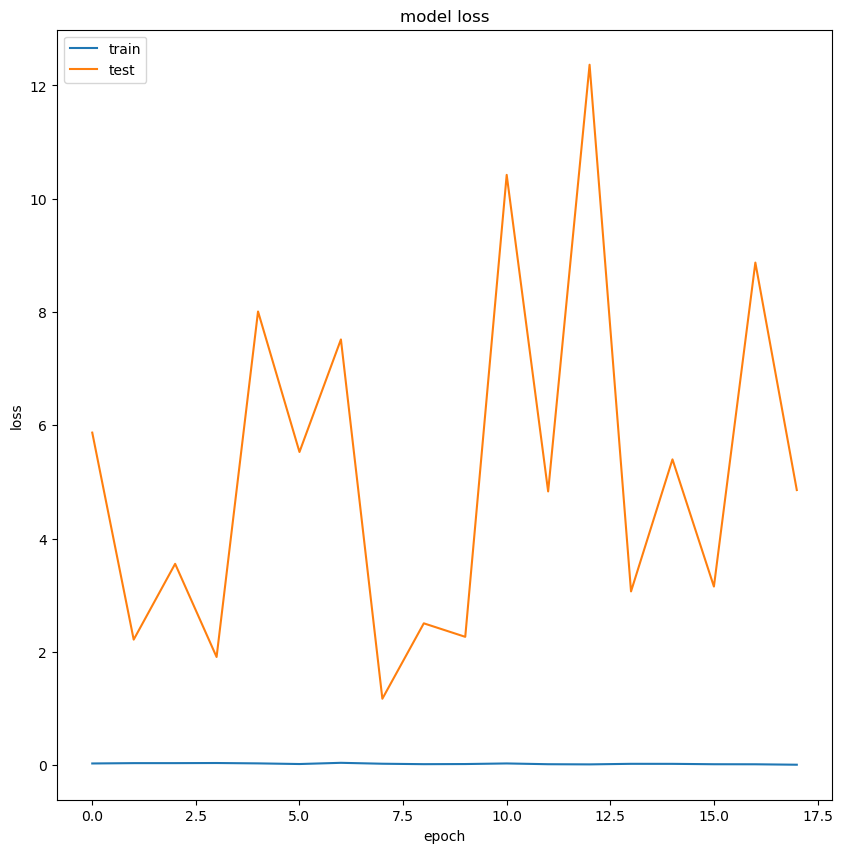

29/29 - 1s - loss: 0.1280 - accuracy: 0.9726 - 617ms/epoch - 21ms/step
Accuracy: 0.9725615382194519
29/29 [==============================] - 1s 21ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[1613   21   38]
 [   1 1769   49]
 [  46    0 2112]]
precision =  0.9725615153124447 
 recall =  0.9725615153124447


In [84]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_accuracy.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_loss.png")

# training metrics
scores = model.evaluate(seq_arrays, seq_labs, verbose=2, batch_size=200)
print('Accuracy: {}'.format(scores[1]))

# make predictions and compute confusion matrix
y_pred = model.predict(seq_arrays,verbose=1, batch_size=200)
y_true = seq_labs

test_set = pd.DataFrame(y_pred)
test_set.to_csv('classification_submit_train.csv', index = None)

y_true_score = np.argmax(y_true, axis=1)
y_pred_score = np.argmax(y_pred.round(0), axis=1)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_score, y_pred_score)
print(cm)

# compute precision and recall
precision = precision_score(y_true_score, y_pred_score, average='micro')
recall = recall_score(y_true_score, y_pred_score, average='micro')
print( 'precision = ', precision, '\n', 'recall = ', recall)

## Model Validation

2/2 - 0s - loss: 0.2063 - accuracy: 0.9630 - 35ms/epoch - 17ms/step
Accuracy: 0.9629629850387573
2/2 [==============================] - 0s 8ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[18  1  0]
 [ 0 12  0]
 [ 0  1 22]]
Precision:  0.9629629629629629 
 Recall:  0.9629629629629629 
 F1-score: 0.9629629629629629


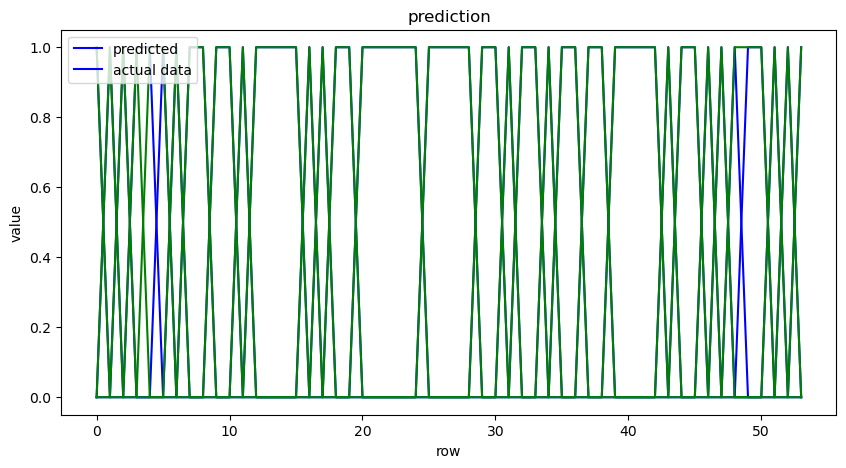

In [85]:
# We pick the last sequence for each id in the validation data
val_arrays = []
val_labs = []

#iterate through ids
for idx in val_df['id'].unique():
    id_df = val_df[val_df.id == idx]
    if len(id_df) >= seq_length:
        val_arrays.append(id_df[sequence_cols].iloc[-seq_length:].to_numpy())
        val_labs.append(id_df['Target'].iloc[-seq_length:].to_numpy()[-1])

#convert to numpy arrays and floats to appease keras/tensorflow        
val_arrays = np.array(val_arrays, dtype = object).astype(np.float32)   
val_labs = np.array(np.eye(num_classes)[val_labs], dtype = object).astype(np.float32)

# test metrics
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('Accuracy: {}'.format(scores_test[1]))

# make predictions and compute confusion matrix
y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('binary_submit_test.csv', index = None)

y_true_test_score = np.argmax(y_true_test, axis=1)
y_pred_test_score = np.argmax(y_pred_test.round(0), axis=1)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test_score, y_pred_test_score)
print(cm)

# compute precision and recall
precision_test = precision_score(y_true_test_score, y_pred_test_score, average='micro')
recall_test = recall_score(y_true_test_score, y_pred_test_score, average='micro')
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Precision: ', precision_test, '\n', 'Recall: ', recall_test,'\n', 'F1-score:', f1_test )

# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test.round(0), color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("model_verify.png")

In [93]:
#Transforming prediction values to training numerical class value
y_pred_output_2=[]
for i in y_pred.round(0):
    if(i[0]==1.0 and i[1]==0.0 and i[2]==0.0):
        y_pred_output_2.append(0)
    elif(i[0]==0.0 and i[1]==1.0 and i[2]==0.0):
        y_pred_output_2.append(1)
    elif(i[0]==0.0 and i[1]==0.0 and i[2]==1.0):
        y_pred_output_2.append(2)
    else:
        y_pred_output_2.append(-1)

In [94]:
#Transforming prediction values to testing numerical class value
y_pred_output=[]
for i in y_pred_test:
    if(i[0].round(0)==1.0 and i[1].round(0)==0.0 and i[2].round(0)==0.0):
        y_pred_output.append(0)
    elif(i[0].round(0)==0.0 and i[1].round(0)==1.0 and i[2].round(0)==0.0):
        y_pred_output.append(1)
    elif(i[0].round(0)==0.0 and i[1].round(0)==0.0 and i[2].round(0)==1.0):
        y_pred_output.append(2)
    else:
        y_pred_output.append(-1)
print(y_pred_output)

[0, 1, 2, 1, 1, 0, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 0, 2, 2, 0, 1, 1, 2, 2, 0, 0, 0, 0, 2, 0, 0, 1, 0, 1, 2, 2, 1, 0, 2]


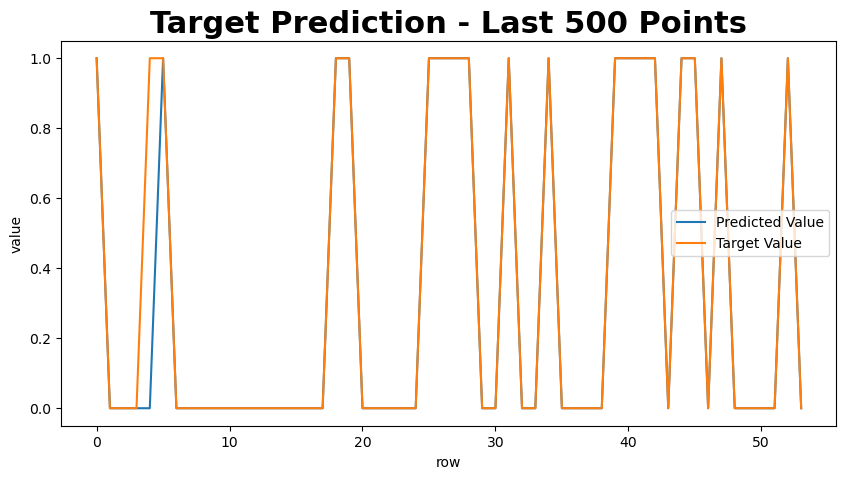

In [95]:
#Plot first second 500 data points/predictions for Target
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:,0].round(0), label = 'Predicted Value')
plt.plot(y_true_test[-500:,0], label = 'Target Value')
plt.title('Target Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

In [96]:
#Storing the output values to a Dataframe to use for Dashboard
count=0
data_file_2=pd.DataFrame()
for idx in train_df['id'].unique():
    id_df = train_df[train_df['id'] == idx]
    num_rows = len(id_df)
    for start in range(0, num_rows - seq_length):
        end = start + seq_length
        id_df.loc[start:,'predicted_values'] = y_pred_output_2[count]
        count=count+1
    data_file_2 = data_file_2.append(id_df, ignore_index=True)

In [97]:
data_file_2.to_csv("household_power_sensors_2.csv")

# CNN

## Model Training

In [233]:
# define path to save model
model_path = 'classification_model_cnn.h5'

# The first layer is an Conv1D layer with 16 units followed by another Conv1D layer with 64 units. 
# MaxPooling1D is also applied after each Conv1D layer. 
# Final layer is a Dense output layer with 3 unit and sigmoid activation since this is a classification problem.
# build the network
nb_features = seq_arrays.shape[2]
nb_out = seq_labs.shape[1]

model_1 = Sequential()
model_1.add(Conv1D(filters=16, kernel_size=3, activation='relu', padding="causal", input_shape=(seq_length, nb_features)))
model_1.add(MaxPooling1D(pool_size=2))
model_1.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding="causal"))
model_1.add(MaxPooling1D(pool_size=2))
model_1.add(Flatten())
model_1.add(Dense(100, activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(3, activation='sigmoid'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model_1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(model_1.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_28 (Conv1D)          (None, 18, 16)            160       
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 9, 16)            0         
 g1D)                                                            
                                                                 
 conv1d_29 (Conv1D)          (None, 9, 64)             3136      
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 4, 64)            0         
 g1D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 256)               0         
                                                                 
 dense_20 (Dense)            (None, 100)             

In [237]:
# fit the network
history = model_1.fit(seq_arrays, seq_labs, epochs=100, batch_size=200, validation_split=0.02, verbose=2,
              callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='min'),
                           keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

# list all data in history
print(history.history.keys())

Epoch 1/100
28/28 - 0s - loss: 0.6063 - accuracy: 0.6998 - val_loss: 0.9095 - val_accuracy: 0.2743 - 233ms/epoch - 8ms/step
Epoch 2/100
28/28 - 0s - loss: 0.6107 - accuracy: 0.7023 - val_loss: 0.9433 - val_accuracy: 0.4956 - 167ms/epoch - 6ms/step
Epoch 3/100
28/28 - 0s - loss: 0.6108 - accuracy: 0.7000 - val_loss: 1.2530 - val_accuracy: 0.3009 - 164ms/epoch - 6ms/step
Epoch 4/100
28/28 - 0s - loss: 0.6096 - accuracy: 0.7039 - val_loss: 1.4634 - val_accuracy: 0.4513 - 151ms/epoch - 5ms/step
Epoch 5/100
28/28 - 0s - loss: 0.5901 - accuracy: 0.7215 - val_loss: 1.1751 - val_accuracy: 0.1593 - 156ms/epoch - 6ms/step
Epoch 6/100
28/28 - 0s - loss: 0.5788 - accuracy: 0.7258 - val_loss: 1.1105 - val_accuracy: 0.1327 - 174ms/epoch - 6ms/step
Epoch 7/100
28/28 - 0s - loss: 0.6010 - accuracy: 0.7063 - val_loss: 1.2505 - val_accuracy: 0.2920 - 170ms/epoch - 6ms/step
Epoch 8/100
28/28 - 0s - loss: 0.5518 - accuracy: 0.7280 - val_loss: 1.2340 - val_accuracy: 0.2478 - 168ms/epoch - 6ms/step
Epoch 9/

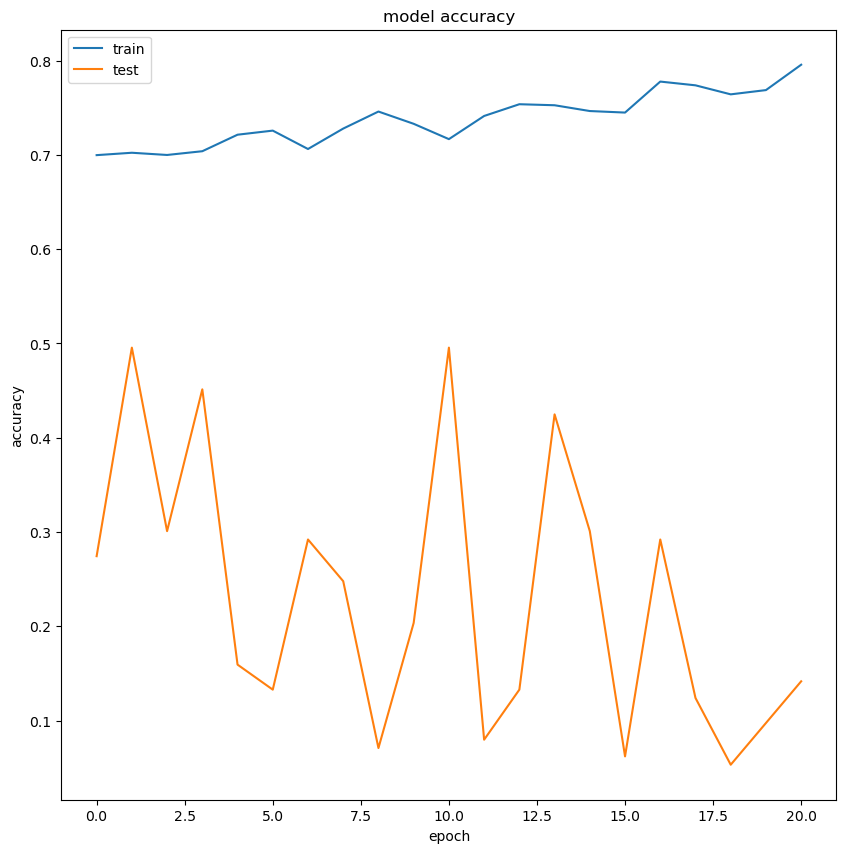

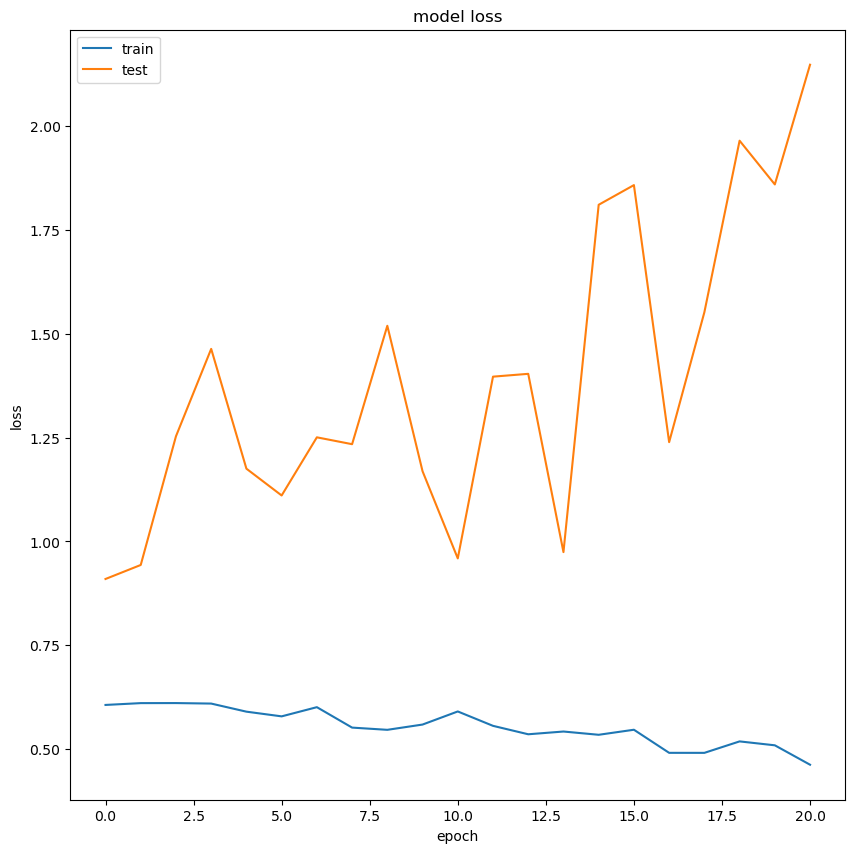

29/29 - 0s - loss: 0.4471 - accuracy: 0.8079 - 78ms/epoch - 3ms/step
Accuracy: 0.807930588722229
29/29 [==============================] - 0s 2ms/step


In [238]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_accuracy_cnn.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_loss_cnn.png")

# training metrics
scores = model_1.evaluate(seq_arrays, seq_labs, verbose=2, batch_size=200)
print('Accuracy: {}'.format(scores[1]))

# make predictions and compute confusion matrix
y_pred = model_1.predict(seq_arrays,verbose=1, batch_size=200)
y_true = seq_labs

test_set = pd.DataFrame(y_pred)
test_set.to_csv('classification_submit_train_cnn.csv', index = None)

## Model Validation

2/2 - 0s - loss: 0.4244 - accuracy: 0.8148 - 24ms/epoch - 12ms/step
Accuracy: 0.8148148059844971
2/2 [==============================] - 0s 2ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[18  0  1]
 [ 4  8  0]
 [ 1 16  6]]


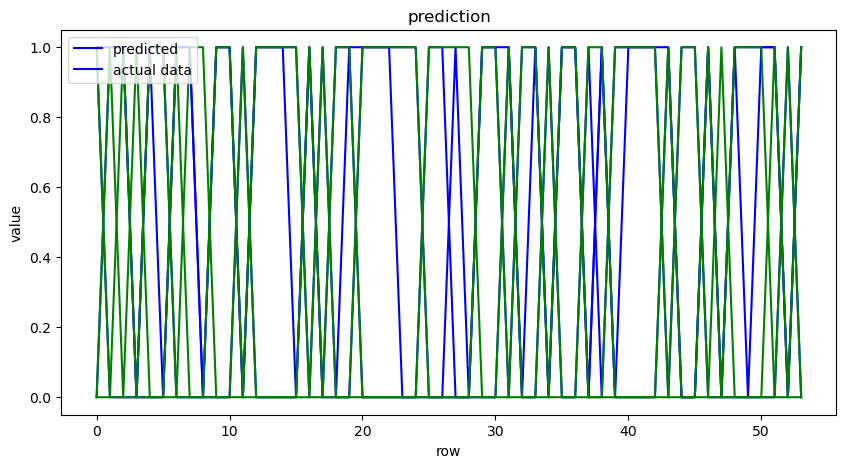

In [239]:
# We pick the last sequence for each id in the validation data
val_arrays = []
val_labs = []

#iterate through ids
for idx in val_df['id'].unique():
    id_df = val_df[val_df.id == idx]
    if len(id_df) >= seq_length:
        val_arrays.append(id_df[sequence_cols].iloc[-seq_length:].to_numpy())
        val_labs.append(id_df['Target'].iloc[-seq_length:].to_numpy()[-1])

#convert to numpy arrays and floats to appease keras/tensorflow        
val_arrays = np.array(val_arrays, dtype = object).astype(np.float32)   
val_labs = np.array(np.eye(num_classes)[val_labs], dtype = object).astype(np.float32)

# test metrics
scores_test = model_1.evaluate(val_arrays, val_labs, verbose=2)
print('Accuracy: {}'.format(scores_test[1]))

# make predictions and compute confusion matrix
y_pred_test = model_1.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('binary_submit_test_cnn.csv', index = None)

y_true_test_score = np.argmax(y_true_test, axis=1)
y_pred_test_score = np.argmax(y_pred_test.round(0), axis=1)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true_test_score, y_pred_test_score)
print(cm)

# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test.round(0), color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("model_verify_cnn.png")

In [240]:
#Transforming prediction values to numerical class value
y_pred_output=[]
for i in y_pred_test:
    if(i[0].round(0)==1.0 and i[1].round(0)==0.0 and i[2].round(0)==0.0):
        y_pred_output.append(0)
    elif(i[0].round(0)==0.0 and i[1].round(0)==1.0 and i[2].round(0)==0.0):
        y_pred_output.append(1)
    elif(i[0].round(0)==0.0 and i[1].round(0)==0.0 and i[2].round(0)==1.0):
        y_pred_output.append(2)
    else:
        y_pred_output.append(-1)
print(y_pred_output)

[-1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, 0, -1, -1, -1, 2, -1, 2, 0, -1, -1, -1, -1, 2, 2, 0, 0, 2, -1, -1, -1, -1, 2, -1, 0, -1, -1, 0, -1, 0, -1, -1, -1, -1, 0, 0, -1, -1, -1, 2, -1, -1, 0, -1]


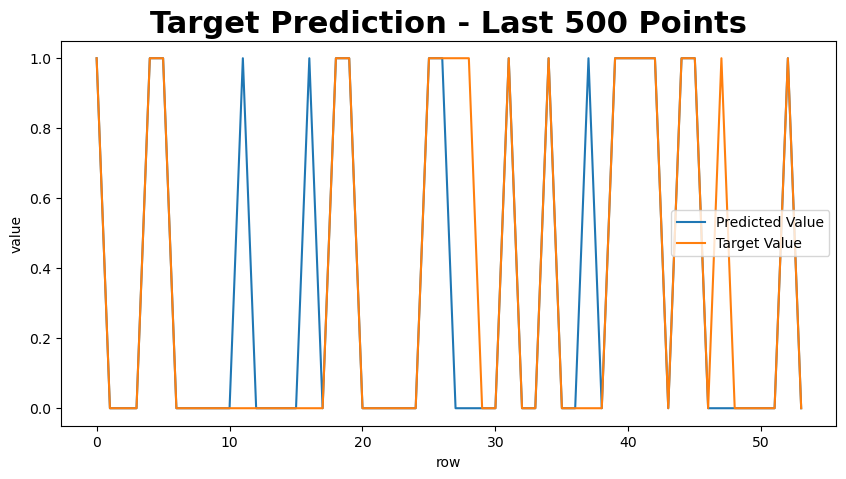

In [241]:
#Plot first second 500 data points/predictions for Target
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:,0].round(0), label = 'Predicted Value')
plt.plot(y_true_test[-500:,0], label = 'Target Value')
plt.title('Target Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify_cnn.png")

# Model Comparison

The LSTM model has shown optimal accuracy of **96% in testing data** and **97% in training data**, which has performed better than the CNN model. CNN model has slittly less accuracy as compared to LSTM model due to lesser deep layers.